In [1]:
import matplotlib.pyplot as mp
import numpy as np
from IPython.display import clear_output
import time
import os
import json
import threading

In [2]:
import tensorflow as tf
from tensorflow import keras 
from keras.layers import *
from keras.datasets import mnist
from keras.models import Model

In [3]:
(xta, yta), (xte, yte) = mnist.load_data()

In [4]:
xta.shape

(60000, 28, 28)

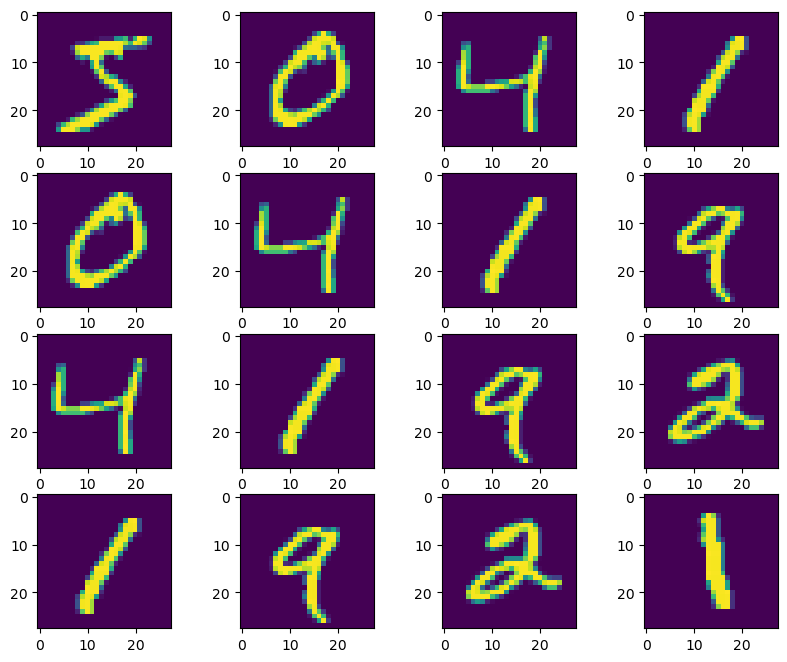

In [5]:
f,a=mp.subplots(4,4,figsize=(10,8))
for i in range(4):
    for j in range(4):
        a[i][j].imshow(xta[i+j].reshape(28,28))

In [6]:
def Generator_Model():
    i1=Input(shape=(1,))
    i2=Input(shape=(100,))
    merge=Concatenate()([i1,i2])
    
    f=Flatten()(merge)
    D1=Dense(7*7*256,use_bias=False)(f)
    B1=BatchNormalization()(D1)
    A1=LeakyReLU()(B1)
    r=Reshape((7,7,256))(A1)

    model=Model(inputs=[i1,i2],outputs=r)
    assert model.output_shape==(None,7,7,256) 

    C1=Conv2DTranspose(128,(5,5),strides=(1,1),padding="same",use_bias=False)(r)
    model=Model(inputs=[i1,i2],outputs=C1)
    assert model.output_shape==(None,7,7,128)
    
    B2=BatchNormalization()(C1)
    A2=LeakyReLU()(B2)
    C2=Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same',activation="relu", use_bias=False)(A2)
    model=Model(inputs=[i1,i2],outputs=C2)
    assert model.output_shape==(None,14,14,64)
    
    
    B3=BatchNormalization()(C2)
    A3=LeakyReLU()(B3)
    C3=Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(A3)
    
    model=Model(inputs=[i1,i2],outputs=C3)
    assert model.output_shape==(None,28,28,1)

    return model
    

In [7]:
def Discriminator_model():
    i=Input(shape=(28,28,1))
    
    C1=Conv2D(64, (5, 5), strides=(2, 2), padding='same')(i)
    A1=LeakyReLU()(C1)
    D1=Dropout(0.3)(A1)
    
    C2=Conv2D(128, (5, 5), strides=(2, 2), padding='same',activation="relu")(D1)
    A2=LeakyReLU()(C2)
    D2=Dropout(0.3)(A2)
    
    F=Flatten()(D2)
    D=Dense(1)(F)
    model=Model(inputs=i,outputs=D)

    return model

In [8]:
gen_model_0=Generator_Model()
gen_model_0.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 101)               │               0 │ input_layer[0][0],         │
│                               │                           │                 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 101)               │               0 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 12544)             │       1,266,944 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 12544)             │          50,176 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 12544)             │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 7, 7, 256)         │               0 │ leaky_re_lu[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose              │ (None, 7, 7, 128)         │         819,200 │ reshape[0][0]              │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 7, 7, 128)         │             512 │ conv2d_transpose[0][0]     │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 7, 7, 128)         │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_1            │ (None, 14, 14, 64)        │         204,800 │ leaky_re_lu_1[0][0]        │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 14, 14, 64)        │             256 │ conv2d_transpose_1[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU)     │ (None, 14, 14, 64)        │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 2,343,488 (8.94 MB)

 Trainable params: 2,318,016 (8.84 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [9]:
dis_model_0=Discriminator_model()
dis_model_0.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def dis_loss(real,fake):
    real_loss=cross_entropy(tf.ones_like(real),real)
    fake_loss=cross_entropy(tf.zeros_like(fake),fake)
    total_loss=(real_loss+fake_loss)*0.5
    return total_loss

In [12]:
def gen_loss(fake):
    return cross_entropy(tf.ones_like(fake), fake)

In [13]:
def generate_tf_noise(shape):
    noise = tf.random.uniform(shape, minval=-1, maxval=1, dtype=tf.float32)
    return noise

In [14]:
def generate_and_display_images(model,e_g_d, num_images=16):

    labels = tf.random.uniform([num_images], minval=0, maxval=10, dtype=tf.int32)
    noise = generate_tf_noise([num_images, 100])
    
    images = model([labels, noise], training=False)
    #images = model([labels], training=False)
    images = (images + 1) / 2

    images = images.numpy()
    clear_output(wait=True)

    mp.figure(figsize=(4, 4))
    for i in range(num_images):
        mp.subplot(4, 4, i + 1)
        mp.imshow(images[i, :, :, 0], cmap='gray')
        mp.axis('off')
    mp.show()
    if e_g_d:
        [print(e_g_d[i]) for i in e_g_d]

In [15]:
def save_model(gen_model,dis_model,epoch):
    gen_model.save(f"generator_model.h5")
    dis_model.save(f"discriminator_model.h5")
    data={"epoch":epoch}
    with open("model_epoch.json","w") as f:
        json.dump(data,f)

In [16]:
def load_model():
    with open("model_epoch.json","r") as f:
        data=json.load(f)
    epoch=data["epoch"]
    gen_model=tf.keras.models.load_model(f"generator_model.h5")
    dis_model=tf.keras.models.load_model(f"discriminator_model.h5")
    return gen_model,dis_model,epoch

In [17]:
def save_thread(gen_model,dis_model,epoch):
    thread=threading.Thread(target=save_model,args=(gen_model,dis_model,epoch))
    thread.start()

In [18]:
def train(xta,yta,epochs,batch=16):

    xta = xta.reshape(-1, 28, 28, 1).astype('float32') / 255
    xta=xta*2-1
    yta = tf.convert_to_tensor(yta, dtype=tf.int32)
    train_ds = tf.data.Dataset.from_tensor_slices((xta, yta)).shuffle(buffer_size=10000).batch(batch)
    
    gen_optimizer = tf.keras.optimizers.Adam(1e-4)
    dis_optimizer = tf.keras.optimizers.Adam(1e-4)
    
    if os.path.exists("model_epoch.json"):
        gen_model,dis_model,load_epoch=load_model()
    else :
        load_epoch=0
        gen_model,dis_model=Generator_Model(),Discriminator_model()
        
    save_interval=15
    last_save_time=time.time()
    
    if os.path.exists("Epoch_Dloss_Gloss.npy"):
        e_g_d=np.load("Epoch_Dloss_Gloss.npy", allow_pickle=True).item()
    else:
        e_g_d=dict()
        np.save("Epoch_Dloss_Gloss.npy",e_g_d)
            
    for epoch in range(load_epoch or 0, epochs):
        start = time.time()
        for images, labels in train_ds:   
            
            current_time=time.time()
            if current_time-last_save_time>save_interval:
                save_thread(gen_model,dis_model,epoch)
                last_save_time=current_time

                
            noise=generate_tf_noise([16,100])
            with tf.GradientTape() as gen_tape,tf.GradientTape() as dis_tape:
                gen_image=gen_model([labels,noise],training=True)

                real_output=dis_model(images,training=True)
                fake_output=dis_model(gen_image,training=True)

                disc_loss=dis_loss(real_output,fake_output)
                gene_loss=gen_loss(fake_output)

            gradient_gen=gen_tape.gradient(gene_loss,gen_model.trainable_variables)
            gradient_dis=dis_tape.gradient(disc_loss,dis_model.trainable_variables)

            gen_optimizer.apply_gradients(zip(gradient_gen,gen_model.trainable_variables))
            dis_optimizer.apply_gradients(zip(gradient_dis,dis_model.trainable_variables))
            generate_and_display_images(gen_model,e_g_d)
        e_g_d[epoch]=f'Time for epoch {epoch}:D_loss={disc_loss:.2f} and G_loss={gene_loss:.2f} is {time.time()-start:.2f} sec'
        np.save("Epoch_Dloss_Gloss.npy",e_g_d)
        save_thread(gen_model,dis_model,epochs)
        generate_and_display_images(gen_model,e_g_d)
    

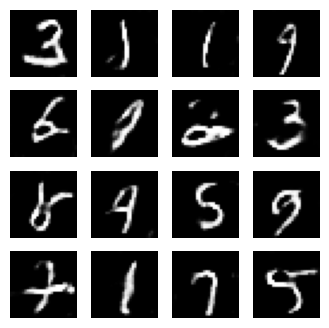

Time for epoch 0:D_loss=0.62 and G_loss=0.74 is 1653.22 sec
Time for epoch 1:D_loss=0.63 and G_loss=0.90 is 1653.16 sec
Time for epoch 2:D_loss=0.60 and G_loss=0.91 is 1626.42 sec
Time for epoch 3:D_loss=0.65 and G_loss=0.85 is 1646.87 sec
Time for epoch 4:D_loss=0.64 and G_loss=0.97 is 1659.07 sec
Time for epoch 5:D_loss=0.64 and G_loss=0.84 is 1648.92 sec


In [31]:
train(xta,yta,6)

In [47]:
if os.path.exists("Epoch_Dloss_Gloss.npy"):
        e_g_d=np.load("Epoch_Dloss_Gloss.npy", allow_pickle=True).item()

In [48]:
e_g_d

{0: 'Time for epoch 0:D_loss=0.62 and G_loss=0.74 is 1653.22 sec',
 1: 'Time for epoch 1:D_loss=0.63 and G_loss=0.90 is 1653.16 sec',
 2: 'Time for epoch 2:D_loss=0.60 and G_loss=0.91 is 1626.42 sec',
 3: 'Time for epoch 3:D_loss=0.65 and G_loss=0.85 is 1646.87 sec',
 4: 'Time for epoch 4:D_loss=0.64 and G_loss=0.97 is 1659.07 sec',
 5: 'Time for epoch 5:D_loss=0.64 and G_loss=0.84 is 1648.92 sec'}

In [32]:
if os.path.exists("model_epoch.json"):
        gen_model,dis_model,load_epoch=load_model()

In [33]:
load_epoch

6

In [40]:
def generate_pred(digit,gen_model):
    noise_shape = [100]  
    noise = tf.random.uniform(noise_shape, minval=-1, maxval=1, dtype=tf.float32)
    if os.path.exists("model_epoch.json"):
        gen_model,_,_=load_model()
    digit_int = tf.convert_to_tensor([digit], dtype=tf.int32)  
    noise = tf.reshape(noise, (1, 100))
    gen_predict_image = gen_model([digit_int,noise],training=False)  
    mp.imshow(gen_predict_image[0,:,:,:], cmap="grey")

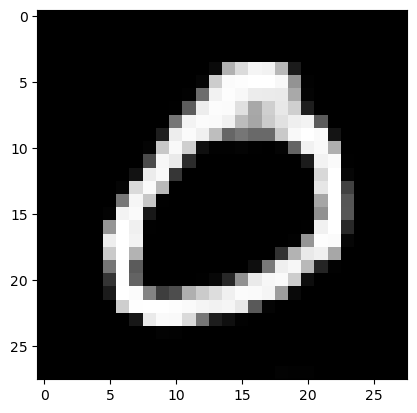

In [49]:
generate_pred(0,gen_model)